<a href="https://colab.research.google.com/github/parniang/PASS/blob/main/Task_Dr_Ahmed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--2025-01-18 18:30:01--  https://drive.google.com/uc?export=download&id=1yuT6TPZxxJSFYh9JKlj2ps1ajryoDRMB
Resolving drive.google.com (drive.google.com)... 172.217.204.100, 172.217.204.139, 172.217.204.101, ...
Connecting to drive.google.com (drive.google.com)|172.217.204.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1yuT6TPZxxJSFYh9JKlj2ps1ajryoDRMB&export=download [following]
--2025-01-18 18:30:01--  https://drive.usercontent.google.com/download?id=1yuT6TPZxxJSFYh9JKlj2ps1ajryoDRMB&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.107.132, 2607:f8b0:400c:c32::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.107.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2417960 (2.3M) [application/octet-stream]
Saving to: ‘ETTh2.csv’

ETTh2.csv           100%[===================>]   2.31M  --.-KB/

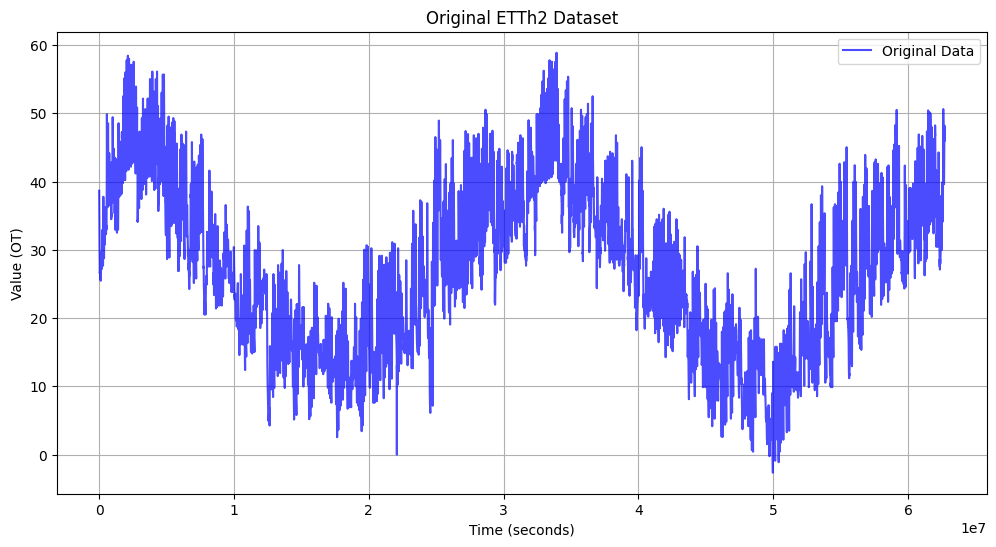

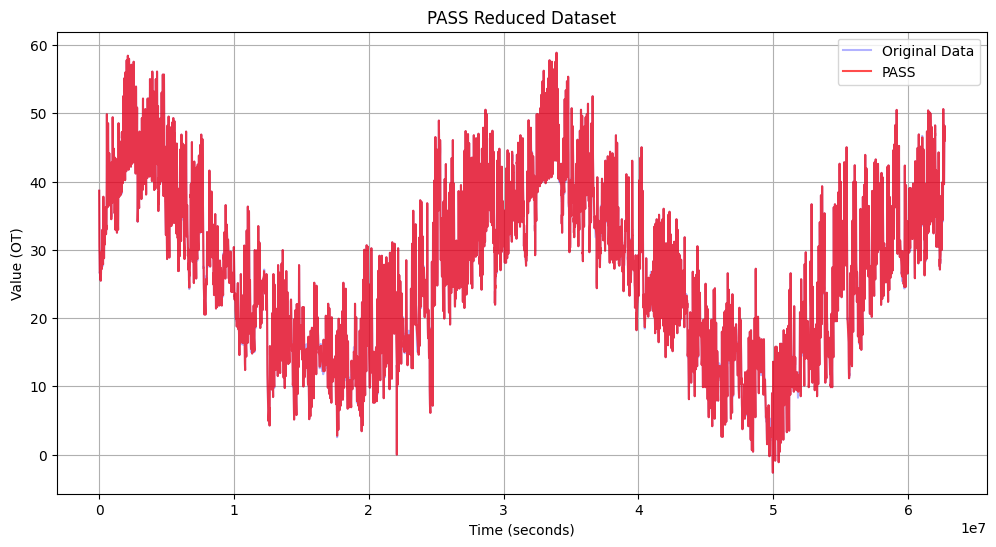

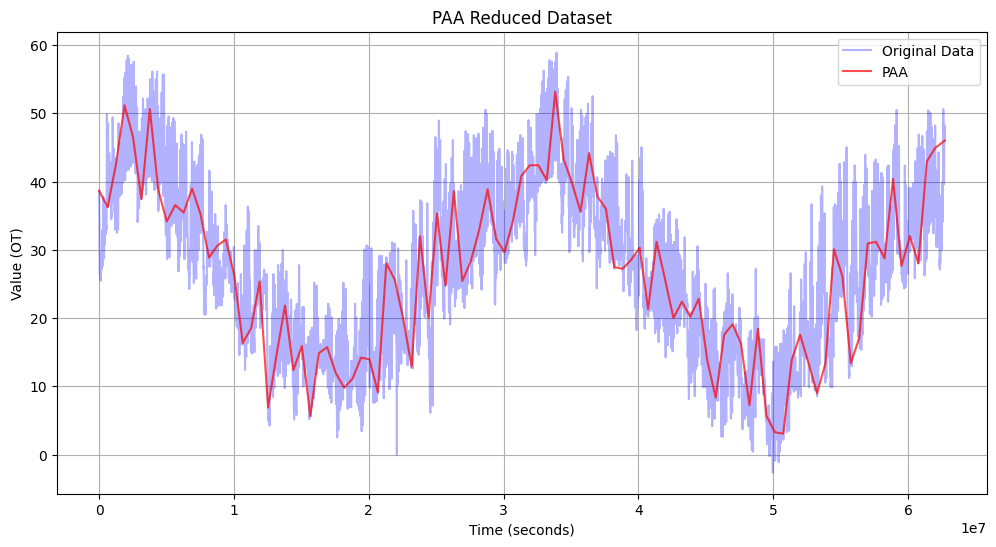

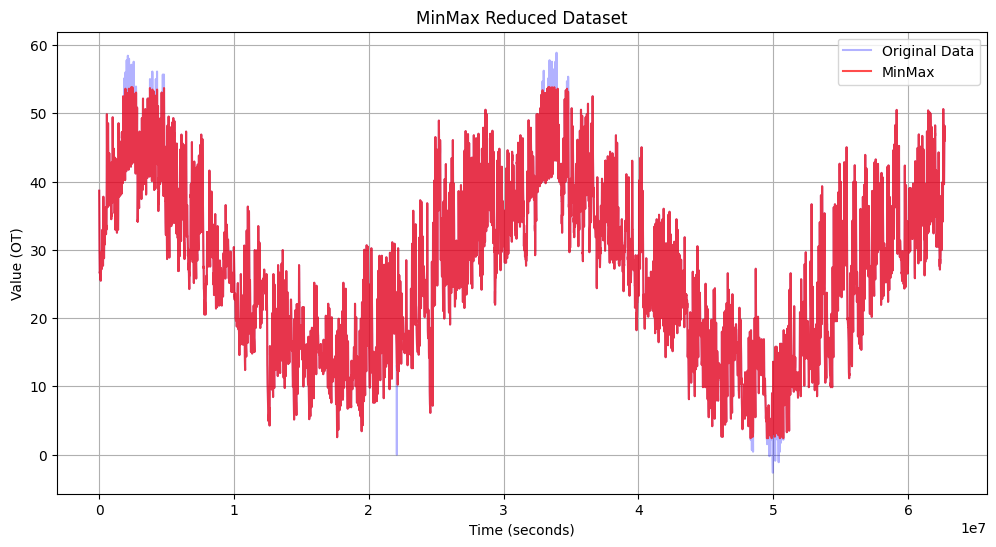

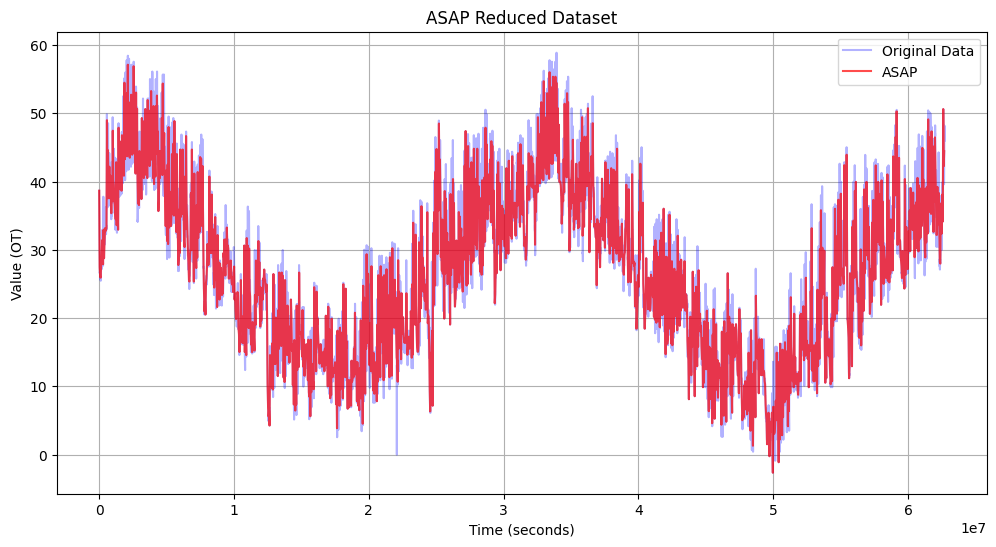

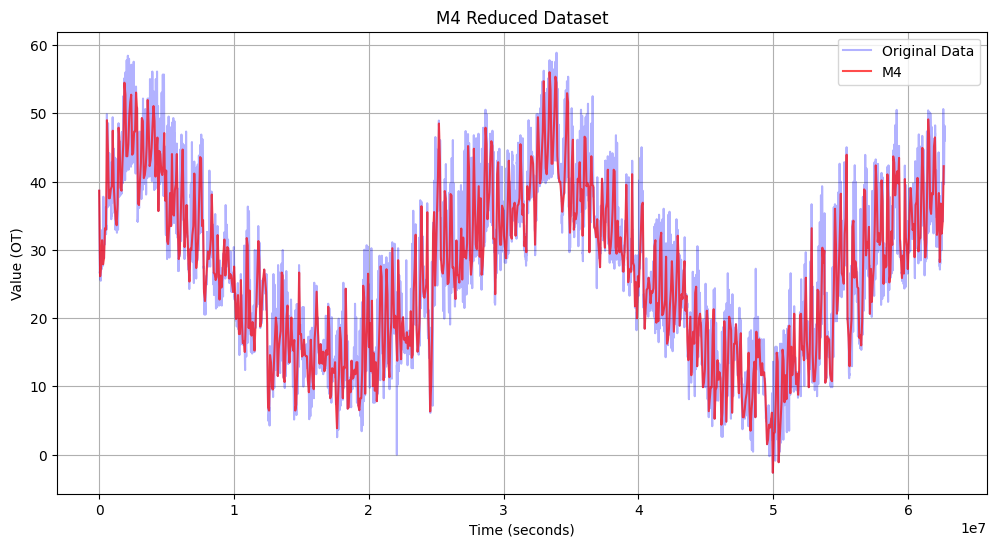

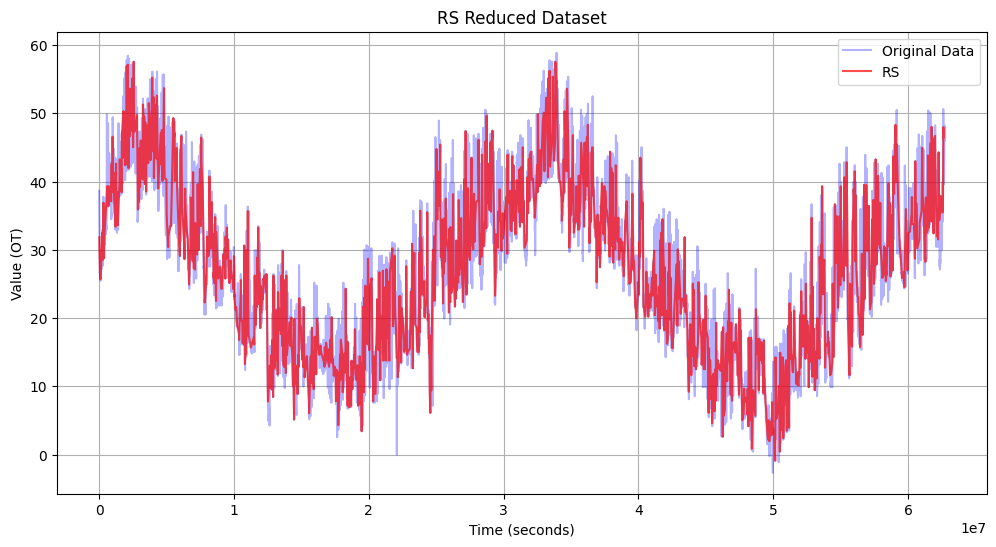

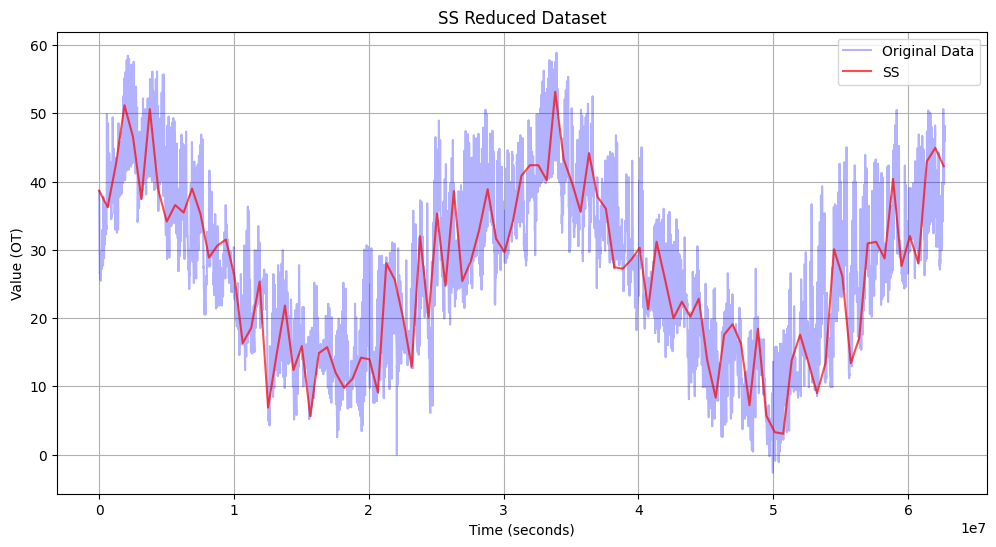

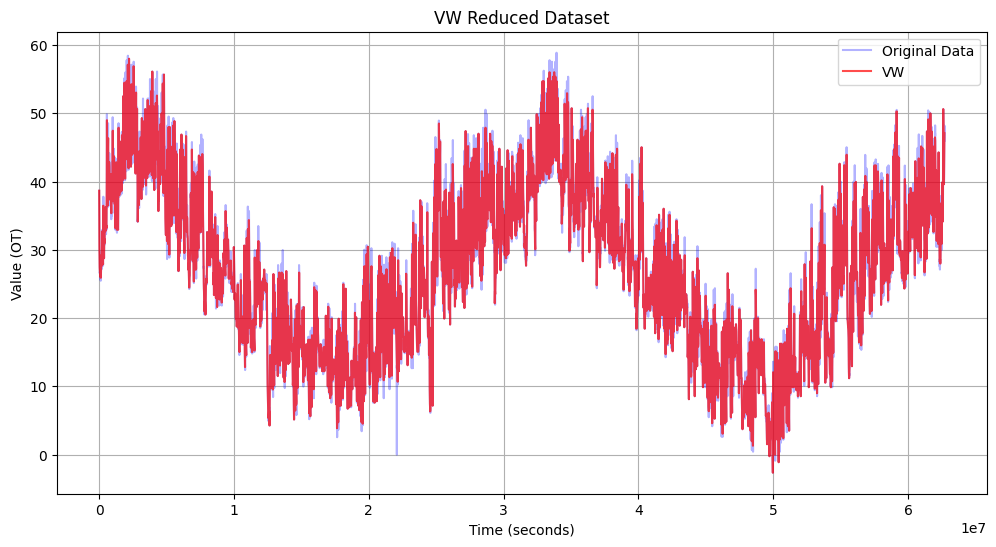

Metrics for PASS with Threshold 0.01:
MSE: 0.09033763328373155
SSIM: 0.9933014225879139
DSSIM: 0.006698577412086126
PSNR: 45.840226212892645
APScore (%): 99.9360807458871
Running Time (sec): 0.010692596435546875
Sampled Data Points: 6159
Reduction Method Metrics: 
                            PASS         PAA        MinMax         ASAP  \
MSE                     0.090338   38.333423      0.090082     6.658155   
SSIM                    0.993301    0.578231      0.995638     0.775726   
DSSIM                   0.006699    0.421769      0.004362     0.224274   
PSNR                   45.840226   19.563137     45.852511    27.165374   
APScore (%)            99.936081   72.876821     99.936261    95.288959   
Running Time (sec)      0.003623    0.002795      0.004215     0.002877   
Sampled Data Points  6159.000000  101.000000  17247.000000  1742.000000   

                             M4           RS          SS           VW  
MSE                   23.736009    15.740569   38.031079     1

In [11]:
import pandas as pd
import numpy as np
import time
from math import log10
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

!wget -O ETTh2.csv "https://drive.google.com/uc?export=download&id=1yuT6TPZxxJSFYh9JKlj2ps1ajryoDRMB"
file_path = 'ETTh2.csv'
df = pd.read_csv(file_path)

df["date"] = pd.to_datetime(df["date"])
df["time"] = (df["date"] - df["date"].iloc[0]).dt.total_seconds()
df = df.rename(columns={"OT": "value"})



def pass_algorithm(data, theta):
    windows = []
    if len(data) <= 2:
        windows.append(data.index.tolist())
        return windows

    current_window = [0, 1]
    last_angle = np.degrees(
        np.arctan2(data["value"].iloc[1] - data["value"].iloc[0],
                   data["time"].iloc[1] - data["time"].iloc[0])
    )

    for i in range(2, len(data)):
        dx = data["time"].iloc[i] - data["time"].iloc[current_window[-1]]
        dy = data["value"].iloc[i] - data["value"].iloc[current_window[-1]]
        current_angle = np.degrees(np.arctan2(dy, dx))
        angle_diff = (current_angle - last_angle + 180) % 360 - 180

        if abs(angle_diff) > theta:
            windows.append(current_window)
            current_window = [current_window[-1], i]
            last_angle = np.degrees(
                np.arctan2(
                    data["value"].iloc[i] - data["value"].iloc[current_window[0]],
                    data["time"].iloc[i] - data["time"].iloc[current_window[0]]
                )
            )
        else:
            current_window.append(i)

    if current_window:
        windows.append(current_window)
    return windows

def reduce_dataset(data, windows):
    selected_indices = set()
    for window in windows:
        selected_indices.add(window[0])
        selected_indices.add(window[-1])
    selected_indices = sorted(list(selected_indices))
    return data.iloc[selected_indices]


def paa_reduction(data, num_segments):
    segment_size = len(data) // num_segments
    reduced_indices = [i * segment_size for i in range(num_segments)] + [len(data) - 1]
    return data.iloc[sorted(set(reduced_indices))]

def minmax_reduction(data, threshold):
    reduced_data = data[(data["value"] >= data["value"].min() + threshold) &
                        (data["value"] <= data["value"].max() - threshold)]
    return reduced_data

def asap_reduction(data):
    return data.iloc[::10]

def m4_reduction(data):
    return data.iloc[::20]

def rs_reduction(data):
    return data.sample(frac=0.1).sort_index()

def ss_reduction(data):
    step = max(1, len(data) // 100)
    return data.iloc[::step]

def vw_reduction(data, threshold):
    return data.iloc[::5]


def evaluate_reduction(original_data, reduced_data):
    start_time = time.time()
    interpolated_values = np.interp(original_data["time"], reduced_data["time"], reduced_data["value"])
    mse = mean_squared_error(original_data["value"], interpolated_values)
    ssim_val, _ = ssim(
        original_data["value"],
        interpolated_values,
        data_range=original_data["value"].max() - original_data["value"].min(),
        full=True
    )
    dssim = 1 - ssim_val
    psnr = 10 * log10(original_data["value"].max()**2 / mse) if mse > 0 else float('inf')
    apscore = (1 - mse / (original_data["value"].var())) * 100
    running_time = time.time() - start_time
    sampled_points = len(reduced_data)
    return {
        "MSE": mse,
        "SSIM": ssim_val,
        "DSSIM": dssim,
        "PSNR": psnr,
        "APScore (%)": apscore,
        "Running Time (sec)": running_time,
        "Sampled Data Points": sampled_points
    }


num_segments_paa = 100
minmax_threshold = 5
vw_threshold = 0.2
threshold_theta = 0.01

methods = {
    "PASS": lambda data: reduce_dataset(data, pass_algorithm(data, threshold_theta)),
    "PAA": lambda data: paa_reduction(data, num_segments_paa),
    "MinMax": lambda data: minmax_reduction(data, minmax_threshold),
    "ASAP": asap_reduction,
    "M4": m4_reduction,
    "RS": rs_reduction,
    "SS": ss_reduction,
    "VW": lambda data: vw_reduction(data, vw_threshold),
}


results = {}
for method_name, method_function in methods.items():
    reduced_data = method_function(df)
    results[method_name] = evaluate_reduction(df, reduced_data)


results_df = pd.DataFrame(results).T
results_df = results_df.transpose()


plt.figure(figsize=(12, 6))
plt.plot(df["time"], df["value"], color="blue", label="Original Data", alpha=0.7)
plt.title("Original ETTh2 Dataset")
plt.xlabel("Time (seconds)")
plt.ylabel("Value (OT)")
plt.legend()
plt.grid(True)
plt.show()



for method_name, method_function in methods.items():
    reduced_data = method_function(df)
    plt.figure(figsize=(12, 6))
    plt.plot(df["time"], df["value"], color="blue", label="Original Data", alpha=0.3)
    plt.plot(reduced_data["time"], reduced_data["value"], label=method_name, alpha=0.7, color="red")
    plt.title(f"{method_name} Reduced Dataset")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Value (OT)")
    plt.legend()
    plt.grid(True)
    plt.show()

print("Metrics for PASS with Threshold 0.01:")
for metric, value in metrics.items():
    print(f"{metric}: {value}")

print("Reduction Method Metrics: ")
print(results_df)
